This tutorial summarizes the tools to predict the LIM outcomes of Zeus21.

In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

---------------------------------------
SL: imported standard CLASS
---------------------------------------


Set up the cosmology, astrophysics and the line parameters.

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [3]:
#set up your parameters here, as an example the CDM (reduced) density
omega_cdm = 0.12
CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omega_cdm)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [4]:
LineParams_input = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4,
                 CII_alpha_SFR_z = -0.07,
                 CII_beta_SFR_0 = 7.1,
                 CII_beta_SFR_z = -0.07,
                 CII_sigma_LSFR = 0.5)

LineParams_input_1 = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 3., # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)

In [5]:
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

LineParams = zeus21.Line_Parameters(LineParams_input) 
LineParams_1 = zeus21.Line_Parameters(LineParams_input_1) 
CorrFClass = zeus21.Correlations_LIM(LineParams, CosmoParams, ClassyCosmo)
CorrFClass_1 = zeus21.Correlations_LIM(LineParams_1, CosmoParams, ClassyCosmo)
print('Correlation functions saved.')

#set up your astro parameters too, here the peak of f*(Mh) as an example
AstroParams = zeus21.Astro_Parameters(CosmoParams)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
CoeffStructure = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams, zmin=ZMIN)
CoeffStructure_1 = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_1, zmin=ZMIN)

zlist = CoeffStructure.zintegral
print('LIM and coefficients stored. Move ahead.')

HMF interpolator built. This ends the cosmology part -- moving to astrophysics.
Correlation functions saved.
LIM and coefficients stored. Move ahead.


/mnt/DATA/programs/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/LIM.py:287: RuntimeWarning: divide by zero encountered in log10
  log10_L = alpha_SFR * np.log10(SFR) + beta_SFR


The standard Zeus21 consider the $\rm SFRD$ from Gallumi and it introduces a deterministic relation between this quantity and $M_h$, such that 

${\rm SFRD} [M_\odot/{\rm yr }/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}}d\log_{10}M_h M_h\frac{dn}{dM_h}{\rm SFR}(M_h)$

Text(0, 0.5, '$\\rm SFRD [M_\\odot/{\\rm yr}/{\\rm Mpc}^3]$')

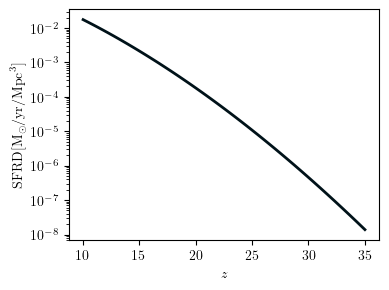

In [6]:
plt.figure(figsize=(4,3))
plt.semilogy(CoeffStructure_21.zGreaterMatrix[:,0],CoeffStructure_21.SFRDbar2D_II[:,0])#,label=r'$R=%g\,{\rm Mpc}$'%CoeffStructure_21.Rtabsmoo[0])
#plt.semilogy(CoeffStructure_21.zGreaterMatrix[:,-10],CoeffStructure_21.SFRDbar2D_II[:,-10],label=r'$R=%g\,{\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[-10],0))
#plt.legend(loc=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\rm SFRD [M_\odot/{\rm yr}/{\rm Mpc}^3]$')

First of all, we consider the relation between the luminosity of the CII line and the SFR, as modelled by Lagache et al. (2018) https://www.aanda.org/articles/aa/pdf/2018/01/aa32019-17.pdf. 
Such relation is defiend as follows.

$\log_{10} \dfrac{L}{L_\odot} = \alpha_{\rm SFR}\log_{10}\dfrac{\rm SFR}{M_\odot/{\rm yr}}+\beta_{\rm SFR}$

$\alpha_{\rm SFR} = 1.4 - 0.07z $

$\beta_{\rm SFR} = 7.1-0.07z$

The first issue we face is that above $z=20$ the $\alpha_{\rm SFR}$ coefficient becomes negative, implying that the luminosity would get larger for smaller, less star forming halos. To overcome this issue, for the moment we set ${\rm min}(\alpha_{\rm SFR}) = 0$, which implies that for $z \geq 20$ the line luminosity is constant with $M_h$ (and with the $\rm SFR$).

Moreover, we consider the case where the parameters $\alpha_{\rm SFR} = 1.4 -0.07\times 10 = 0.7$ and $\beta_{\rm SFR} = 7.1-0.07\times 10 = 6.4$ are constant in $z$ (dashed lines, case [1] in the following plots).

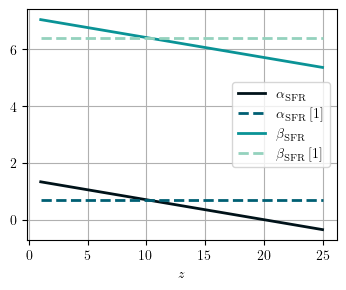

In [7]:
z_test_LIM = np.linspace(1.,25.)

alpha_SFR = lambda z: LineParams.CII_alpha_SFR_0 + LineParams.CII_alpha_SFR_z*z
beta_SFR = lambda z: LineParams.CII_beta_SFR_0 + LineParams.CII_beta_SFR_z*z

alpha_SFR_1 = lambda z: LineParams_1.CII_alpha_SFR_0 + LineParams_1.CII_alpha_SFR_z*z
beta_SFR_1 = lambda z: LineParams_1.CII_beta_SFR_0 + LineParams_1.CII_beta_SFR_z*z

plt.figure(figsize=(4,3))
plt.plot(z_test_LIM,alpha_SFR(z_test_LIM),label=r'$\alpha_{\rm SFR}$')
plt.plot(z_test_LIM,alpha_SFR_1(z_test_LIM),'--',label=r'$\alpha_{\rm SFR}\,[1]$')
plt.plot(z_test_LIM,beta_SFR(z_test_LIM),label=r'$\beta_{\rm SFR}$')
plt.plot(z_test_LIM,beta_SFR_1(z_test_LIM),'--',label=r'$\beta_{\rm SFR}\,[1]$')
plt.xlabel(r'$z$')
plt.legend()
plt.grid()


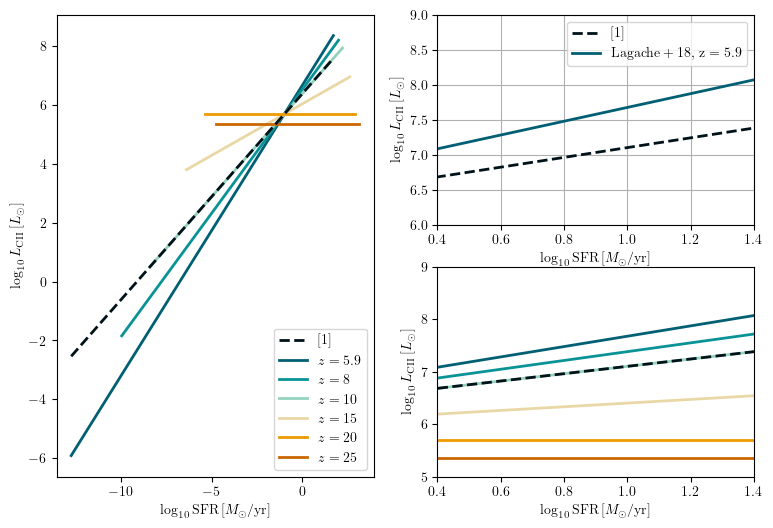

In [8]:
massVector = np.logspace(7,12)
z = [5.9,8.,10.,15.,20.,25.]
plt.figure(figsize=(9,6))
for i in z:
    SFR = LIM.dot_Mstar(AstroParams, CosmoParams, HMFintclass, massVector, z = i)
    LCII = LIM.LineLuminosity(LineParams, AstroParams, CosmoParams, HMFintclass, massVector, z = i)
    LCII_1 = LIM.LineLuminosity(LineParams_1, AstroParams, CosmoParams, HMFintclass, massVector, z = i)

    plt.subplot(121)
    if i == 5.9:
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$[1]$')
    plt.plot(np.log10(SFR),np.log10(LCII),label=r'$z=%g$'%i,zorder=1)
    plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
    plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
    plt.legend(loc=4)
    
    plt.subplot(224)
    if i == 5.9:
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$[1]$')
    plt.plot(np.log10(SFR),np.log10(LCII),label=r'$z=%g$'%i,zorder=1)
    plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
    plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
    plt.xlim(0.4,1.4)
    plt.ylim(5,9)
    
    if i == 5.9:
        plt.subplot(222)
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$\rm [1]$')
        plt.plot(np.log10(SFR),np.log10(LCII),label=r'$\rm Lagache+18,\,z=%g$'%i)
        plt.legend()
        plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
        plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
        plt.xlim(0.4,1.4)
        plt.ylim(6,9)
        plt.grid()

We then model the average luminosity density, as 

$\rho_L [L_\odot/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}} d\log_{10}M_h M_h\dfrac{dn}{dM_h}L({\rm SFR}(M_h))$    

where the array that we create has dimension $N_z \times 1$, in analogy to the $\rm SFRD$ case of the standard Zeus21, which has size $N_z\times N_{R}$, being $R$ the array of smoothing scales used in the peak background split.

In the Lagache case, we obtain a line luminosity that peaks around $z=20$, which is due to the fact that at higher $z$ the fainter galaxies have a larger $L({\rm SFR})$ and are still luminous.

In our modified case, instead, the luminosity simply decreases in $z$ (which seems more reasonable), hence we proceed in our analysis only with this case.

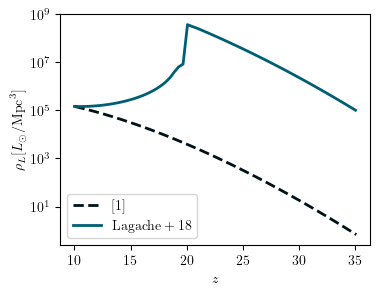

In [9]:
plt.figure(figsize=(4,3))
plt.semilogy(CoeffStructure_1.zGreaterMatrix,CoeffStructure_1.rhoLbar,'--',label=r'$[1]$')
plt.semilogy(CoeffStructure.zGreaterMatrix,CoeffStructure.rhoLbar, label=r'$\rm Lagache+18$')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_L [L_\odot/{\rm Mpc}^3]$')
plt.legend(loc=3)

The next step is to model the average intensity/brightness temperature measured in the survey, as 

$\bar{I}_\nu [L_\odot {\rm/cm^2/sr/Hz}] \,= \dfrac{c}{4\pi H(z)\nu_{\rm rest}}{\rho}_L(z)$

$\qquad \quad\qquad \bar{T}_\nu [\mu K] = \dfrac{c^3(1+z^2)}{8\pi k_B H(z)\nu_{\rm rest}^3}{\rho}_L(z)$

$\qquad\qquad\qquad\qquad\,\, = c_1^{\rm LIM}(z)c_2^{\rm LIM}(z)$

Note that, differently from the standard Zeus21 case, both the coefficients only depend on $z$ and not on $R$. We continue using $\bar{T}_\nu$.

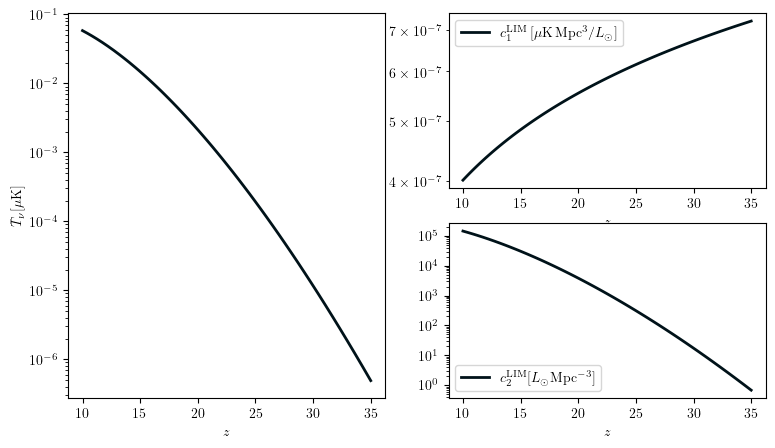

In [10]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.semilogy(zlist,CoeffStructure_1.Inu_avg)
plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{T}_{\nu} [\mu {\rm K}]$')

plt.subplot(222)
plt.semilogy(zlist,CoeffStructure_1.coeff1_LIM,label=r'$c_1^{\rm LIM}\,[\mu {\rm K\,Mpc^3}/L_\odot]$')
plt.xlabel(r'$z$')
plt.legend()

plt.subplot(224)
plt.semilogy(zlist,CoeffStructure_1.coeff2_LIM,label=r'$c_2^{\rm LIM} [L_\odot{\rm Mpc^{-3}}]$')
plt.xlabel(r'$z$')
plt.legend(loc=3)

We now proceed to compute the LIM auto-correlation and power spectrum. 

First of all, we define the tophat window function $W(k,R_0)$, where $R_0$ is the $\_R$ resolution value that we plugged in the Line Parameters. We here compare two cases, $R_0 = 0.5 {\rm Mpc}$ and $R_0 = 3 {\rm Mpc}$ (which is the one that then we use in the followinf analysis).

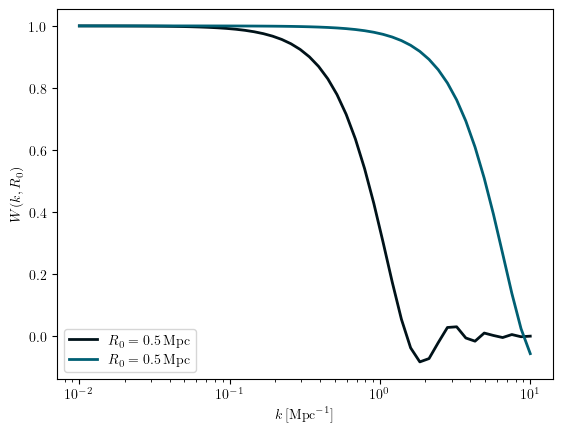

In [11]:
k = np.logspace(-2,1)
W_05 = CorrFClass.Window(k,LineParams._R)
W_3 = CorrFClass_1.Window(k,LineParams_1._R)

plt.semilogx(k,W_3,label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams._R)
plt.semilogx(k,W_05,label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams._R)
plt.xlabel(r'$k\,[{\rm Mpc}^{-1}]$')
plt.ylabel(r'$W(k,R_0)$')
plt.legend()

And we then compute the linear matter correlation function smoothed over these windows, namely

$\xi(r) = {\rm FT}[P(k)W_{R_0}(k)^2]$

This array has size $N_{R_S} \times N_{R_S} \times N_k = 1 \times 1 \times N_z$.

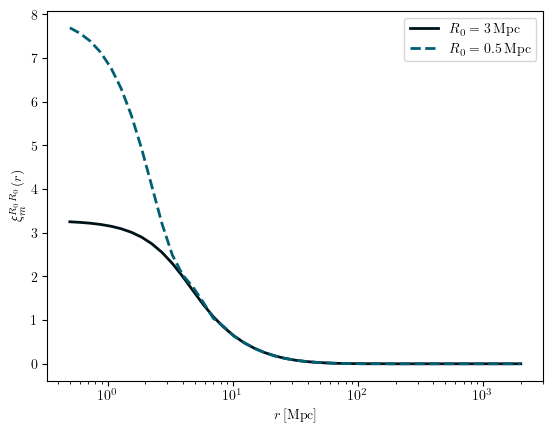

In [16]:
xi_05 = CorrFClass.xi_LIMLIM_CF
xi_3 = CorrFClass_1.xi_LIMLIM_CF

plt.semilogx(CorrFClass_1.rlist_CF,xi_3[0,0,:],label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_1._R)
plt.semilogx(CorrFClass.rlist_CF,xi_05[0,0,:],'--',label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams._R)
plt.xlabel(r'$r\,[{\rm Mpc}]$')
plt.ylabel(r'$\xi_m^{R_0R_0}(r)$')
plt.legend()

We then compute the window $W_{\rm LIM} = c_2^{\rm LIM}\gamma_{R_0}^{\rm LIM}D(z)$, which has size $N_z\times 1$. We transpose it ($1\times N_z$) and we add the $r$ array, so to get $1\times N_z \times N_r(k)$.

In [36]:
win =CoeffStructure_1.gammaLIM_index * zeus21.cosmology.growth(CosmoParams, CoeffStructure_1.gammaLIM_index)[:,0]
win

array([[1.019841  , 1.00481034, 0.98880688, ..., 0.27208022, 0.26484744,
        0.2577628 ],
       [1.03906745, 1.02375343, 1.00744827, ..., 0.27720959, 0.26984046,
        0.26262224],
       [1.06015472, 1.0445299 , 1.02789384, ..., 0.2828354 , 0.27531671,
        0.26795201],
       ...,
       [4.5410832 , 4.47415561, 4.40289645, ..., 1.21150153, 1.17929587,
        1.1477498 ],
       [4.67248919, 4.60362492, 4.53030371, ..., 1.24655893, 1.21342133,
        1.1809624 ],
       [4.80837618, 4.73750917, 4.66205562, ..., 1.2828118 , 1.24871048,
        1.21530757]])

In [37]:
np.shape(np.transpose(win)+CosmoParams._Rtabsmoo)

ValueError: operands could not be broadcast together with shapes (64,64) (45,) 

In [17]:
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PSLIM = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, ClassyCosmo, CorrFClass_1, 'here we will put 21cm coeffs', CoeffStructure_1, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

IndexError: index 1 is out of bounds for axis 0 with size 1

(100000000.0, 1e+16)

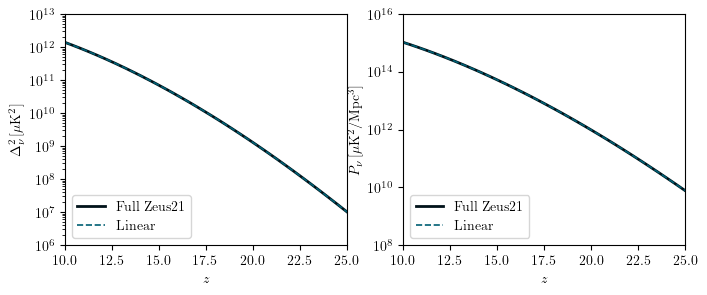

In [16]:
#choose a k to plot
klist = PSLIM.klist_PS
kchoose=0.3;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.semilogy(zlist,PSLIM.Deltasq_LIM[:,_ik])
plt.semilogy(zlist,PSLIM.Deltasq_LIM_lin[:,_ik],'--', linewidth=1.2)

plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{\nu}\,\rm[\mu {\rm K}^2]$');
plt.legend([r'Full Zeus21', r'Linear'],loc=3)

plt.xlim([10, 25])
plt.ylim([1e6,1e13])

plt.subplot(122)
plt.semilogy(zlist,PSLIM.Deltasq_LIM[:,_ik] / PSLIM._k3over2pi2[_ik])
plt.semilogy(zlist,PSLIM._Pk_LIM_lin[:,_ik],'--', linewidth=1.2)

plt.xlabel(r'$z$');
plt.ylabel(r'$P_{\nu}\,\rm[\mu {\rm K}^2/Mpc^3]$');
plt.legend([r'Full Zeus21', r'Linear'],loc=3)

plt.xlim([10, 25])
plt.ylim([1e8,1e16])

(0.01, 1)

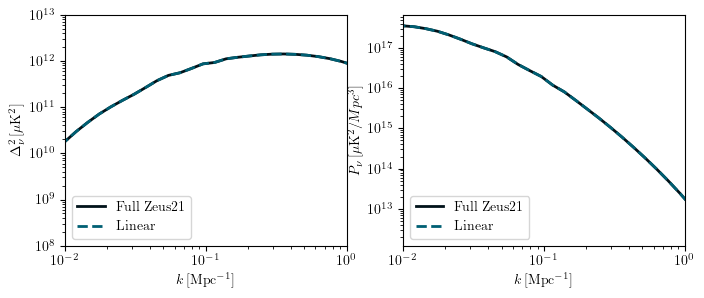

In [17]:
#choose a z to plot
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))


plt.figure(figsize=(8,3))
plt.subplot(121)
plt.loglog(klist,PSLIM.Deltasq_LIM[_iz])
plt.loglog(klist,PSLIM.Deltasq_LIM_lin[_iz], '--')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend([r'Full Zeus21', r'Linear'],loc=3)

plt.xlim([1e-2,1])
plt.ylim([1e8,1e13])

plt.subplot(122)
plt.loglog(klist,PSLIM.Deltasq_LIM[_iz] / PSLIM._k3over2pi2)
plt.loglog(klist,PSLIM._Pk_LIM_lin[_iz], '--')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$P_{\nu}\,[\mu{\rm K}^2/Mpc^3]$');
plt.legend([r'Full Zeus21', r'Linear'],loc=3)

plt.xlim([1e-2,1])
#plt.ylim([1e9,1e12])

1.0000000000000007


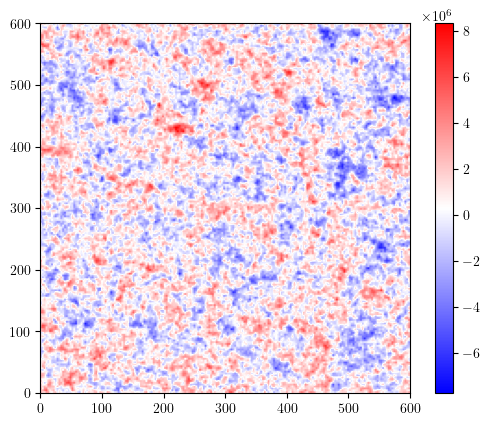

In [18]:
Mapz10 = zeus21.CoevalMaps_LIM(CoeffStructure_1, PSLIM, 10., KIND=0)

print(np.mean(Mapz10.LIMmap)/Mapz10.rhoL_avg) #should have the correct mean

_islice = 0
plt.imshow(Mapz10.LIMmap[_islice],extent=(0,Mapz10.Lbox,0,Mapz10.Lbox),cmap='bwr') 
plt.colorbar()
plt.show()